In [86]:
import pandas as pd
train_data = pd.read_csv('/content/drive/MyDrive/SPH 6004/Assignment 2/Version 2/merged_train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/SPH 6004/Assignment 2/Version 2/merged_test.csv')
holdout_data = pd.read_csv('/content/drive/MyDrive/SPH 6004/Assignment 2/Version 2/merged_holdout.csv')

In [ ]:
los_icu_stats = train_data['los_icu'].describe()

los_icu_stats

count    64985.000000
mean         5.209080
std          6.481275
min          1.000000
25%          1.890000
50%          3.040000
75%          5.820000
max        101.730000
Name: los_icu, dtype: float64

In [87]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def create_sequences_with_targets(data, timestep=5):
    numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()
    # Include the target column in the processing, but do not include it in the scaling
    numeric = data[numeric_columns]  # Assuming 'los_icu' is in numeric_columns

    # Exclude 'id' and 'charttime' columns and target columns you don't want to scale
    columns_to_scale = [col for col in numeric.columns if col not in ['id', 'charttime', 'los_icu', 'icu_death', 'icu_outcome']]

    # Group data by 'id'
    grouped_data = data.groupby('id')
    # Initialize MinMaxScaler
    scaler = MinMaxScaler()

    # Lists to store time series and targets
    time_series = []
    targets = []

    for _, group_data in grouped_data:
        # Select columns to keep for scaling
        scaled_data = scaler.fit_transform(group_data[columns_to_scale].iloc[-timestep:])
        # Select the target corresponding to the last entry of the group (or another strategy)
        target_data = group_data['los_icu'].values[-1] if len(group_data) >= timestep else group_data['los_icu'].values[0]

        if len(group_data) >= timestep:
            time_series.append(scaled_data)
            targets.append(target_data)
        else:
            padding_rows = timestep - len(group_data)
            repeated_data = np.tile(scaled_data[0], (padding_rows, 1))
            combined_data = np.vstack([repeated_data, scaled_data])
            time_series.append(combined_data)
            targets.append(target_data)

    return np.array(time_series), np.array(targets)

In [88]:
train_sequences, train_targets = create_sequences_with_targets(train_data)
test_sequences, test_targets = create_sequences_with_targets(test_data)
holdout_sequences, holdout_targets = create_sequences_with_targets(holdout_data)

In [ ]:
train_sequences.shape, train_targets.shape

((14289, 5, 60), (14289,))

In [89]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D

model = Sequential([
    Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(timestep, train_sequences.shape[2])),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=2, activation='relu'),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 4, 32)             3872      
                                                                 
 max_pooling1d_13 (MaxPooli  (None, 2, 32)             0         
 ng1D)                                                           
                                                                 
 conv1d_17 (Conv1D)          (None, 1, 64)             4160      
                                                                 
 flatten_8 (Flatten)         (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 50)                3250      
                                                                 
 dense_17 (Dense)            (None, 1)                 51        
                                                      

In [90]:
print(model.layers[0].input_shape)

(None, 5, 60)


In [91]:
history = model.fit(train_sequences, train_targets, epochs=10, validation_data = (holdout_sequences, holdout_targets))

Epoch 1/10
447/447 [==============================] - 2s 2ms/step - loss: 37.4066 - mae: 3.5689 - val_loss: 30.1112 - val_mae: 3.6684
Epoch 2/10
447/447 [==============================] - 1s 2ms/step - loss: 36.2811 - mae: 3.5505 - val_loss: 29.5356 - val_mae: 3.3588
Epoch 3/10
447/447 [==============================] - 1s 2ms/step - loss: 36.0319 - mae: 3.5313 - val_loss: 29.4523 - val_mae: 3.3286
Epoch 4/10
447/447 [==============================] - 1s 2ms/step - loss: 35.8066 - mae: 3.5286 - val_loss: 29.8491 - val_mae: 3.6205
Epoch 5/10
447/447 [==============================] - 1s 2ms/step - loss: 35.7743 - mae: 3.5296 - val_loss: 29.4907 - val_mae: 3.2608
Epoch 6/10
447/447 [==============================] - 1s 2ms/step - loss: 35.4662 - mae: 3.5105 - val_loss: 29.7723 - val_mae: 3.4217
Epoch 7/10
447/447 [==============================] - 1s 2ms/step - loss: 35.3107 - mae: 3.4975 - val_loss: 29.8567 - val_mae: 3.5582
Epoch 8/10
447/447 [==============================] - 1s 2ms/s

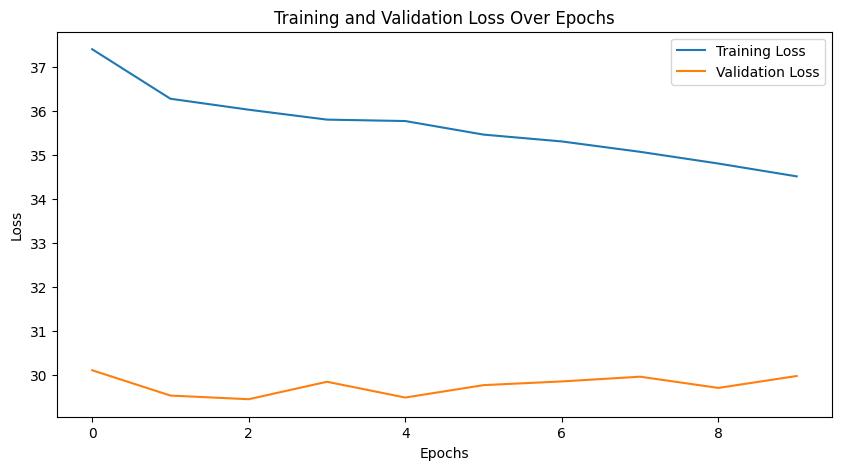

In [92]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [93]:
model.evaluate(test_sequences, test_targets)

128/128 [==============================] - 0s 1ms/step - loss: 35.5847 - mae: 3.5566


[35.58467102050781, 3.556631326675415]

In [94]:
test_predict = model.predict(test_sequences)
test_predict = np.round(test_predict, 2)

128/128 [==============================] - 0s 990us/step


In [95]:
test_predict

array([[4.39],
       [5.65],
       [5.19],
       ...,
       [5.82],
       [4.29],
       [5.5 ]], dtype=float32)

In [96]:
test_targets

array([2.87, 3.32, 2.42, ..., 2.37, 5.12, 1.2 ])